In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html

import matplotlib.patches as mpatches
from physoce import tseries as ts 
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy import stats
from scipy.signal import periodogram
from datetime import timedelta

In [2]:
#Import kelp dataframe
kelp = pd.read_csv('Kelp/kelp_data.csv', index_col=0, parse_dates = True)
kelp.Date = pd.to_datetime(kelp.Date) #Makes "Date" column a datetime object

In [3]:
# Calculate latitude and longitude
def find_coords(lat1, lon1, heading, dist):
    R = 6378100 # Radius of the Earth in meters
    Ad = dist/R # Angular distance of point b
    lat1 = lat1 * (np.pi/180)
    lon1 = lon1 * (np.pi/180)
    theta = heading * (np.pi/180) # The bearing towards point b in radians
    
    #lat2 = np.arcsin((np.sin(lat1) * np.cos(Ad)) + (np.cos(lat1)*np.sin(Ad)*np.cos(theta)))
    lat2 = np.arcsin(np.sin(lat1) * np.cos(Ad) + np.cos(lat1) * np.sin(Ad) * np.cos(theta)) * (180/np.pi)
    lon2 = (lon1 + np.arctan2(np.sin(theta) * np.sin(Ad) * np.cos(lat1), np.cos(Ad) - np.sin(lat1) * np.sin(lat2))) * (180/np.pi)
    return lat2, lon2

In [4]:
lat1 = 36.56196
lon1 = -121.94176

lat2, lon2 = find_coords(lat1, lon1, kelp.Heading, kelp.Distance)

kelp['Latitude'] = lat2
kelp['Longitude'] = lon2

In [5]:
#Use coordinates of the central mooring to find coordinates of other instruments

#Original mooring coordinates
lat1 = 36.56196
lon1 = -121.94176

#Coordinates of adcp and adv during during first three weeks of deployments
adcp1_lat, adcp1_lon = find_coords(lat1, lon1, 175, 2)
adv_lat, adv_lon = find_coords(lat1, lon1, 90, 4)

kelp_w1 = kelp.loc[kelp.Date.dt.day == 26, :]
kelp_w2 = kelp.loc[kelp.Date.dt.day == 1, :]
kelp_w3 = kelp.loc[kelp.Date.dt.day == 11, :]

# adcp location is different during these last surveys
adcp2_lat, adcp2_lon = find_coords(lat1, lon1, 230, 1.75)
kelp_w4 = kelp.loc[kelp.Date.dt.day == 25, :]
kelp_w5 = kelp.loc[kelp.Date.dt.day == 30, :]

In [6]:
adcp1_lat,adcp1_lon

(36.56194210195769, -121.94175918358738)

In [7]:
adv_lat, adv_lon

(36.56195999999164, -121.94174126537672)

In [8]:
adcp2_lat,adcp2_lon

(36.56194989498659, -121.9417662787946)

In [9]:
kelp_w1

,Date,Heading,Distance,Diameter,Notes,Latitude,Longitude
0,2022-07-26,0,3.50,0.954930,NaN,36.561991,-121.941760
1,2022-07-26,0,4.00,1.591549,NaN,36.561996,-121.941760
2,2022-07-26,45,4.20,11.140846,NaN,36.561987,-121.941746
3,2022-07-26,45,4.60,1.909859,NaN,36.561989,-121.941745
4,2022-07-26,45,4.70,1.273240,NaN,36.561990,-121.941744
5,2022-07-26,45,5.30,2.387324,NaN,36.561994,-121.941742
6,2022-07-26,45,7.30,3.501409,NaN,36.562006,-121.941736
7,2022-07-26,90,9.40,2.300000,NaN,36.561960,-121.941716
8,2022-07-26,90,10.00,2.900000,NaN,36.561960,-121.941713
9,2022-07-26,90,10.00,5.900000,OOB,36.561960,-121.941713


In [128]:
#Export dataframe to csv
kelp.to_csv('Kelp/kelp_data.csv')

Text(0.5, 1.0, 'Stipe Bundle Map')

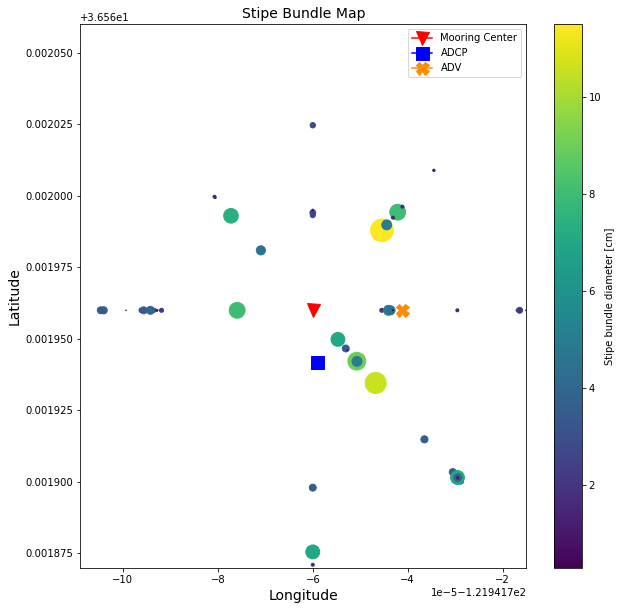

In [14]:
#survey_dates[0:3]
data = kelp_w3

plt.figure(figsize = (10,10))

plt.scatter(data.Longitude, data.Latitude, s=5*(np.pi*((data.Diameter/2)**2)), c = data.Diameter)
plt.plot(lon1, lat1, marker = "v", ms = 13, color = 'red', label = 'Mooring Center')
plt.plot(adcp1_lon, adcp1_lat, marker = "s", ms = 13, color = 'blue', label = 'ADCP')
#plt.plot(adcp2_lon, adcp2_lat, marker = "s", ms = 13, color = 'blue', label = 'ADCP')
plt.plot(adv_lon, adv_lat, marker = "X", ms = 13, color = 'darkorange', label = 'ADV')
plt.colorbar(label = 'Stipe bundle diameter [cm]')

plt.legend()

plt.ylim(36.56187,36.56206)
plt.xlim(-121.941809,-121.941715)
plt.ylabel('Latitude', fontsize = 14)
plt.xlabel('Longitude', fontsize = 14)
plt.title('Stipe Bundle Map', fontsize = 14)

#plt.savefig('Plots/Dep1_kelp_current_histograms')

In [ ]:
tmean = temp.mean() # 12.29
kv = .000001225 # kv found on https://www.omnicalculator.com/physics/water-viscosity
Re = 1000 # Re number where turbulence is observed
Vmean = adv.Magnitude.mean() # .0343 m/s

# Re = Vmean * diameter / kv, diameter = Re * kv/ Vmean
diam = ((Re * kv)/Vmean)

In [ ]:
# Above data coincides with weeks 2 and 3
# survey_dates[1:3]
kelp_diam_w1_3 = kelp_diam_w2_3.append(kelp_diam_w1)

In [ ]:
#survey_dates[0:3]
#kelp_diam_w1_3.stack()
plt.figure(figsize = (20,8))

plt.subplot(131)
plt.hist(kelp_diam_w1_3.stack()/100, bins =20, color = 'goldenrod')
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Diameter (m)', fontsize = 14)
plt.title('Cumulative Stipe Bundle Diameters', fontsize = 14)

plt.subplot(132)
plt.hist(adv01_1min.Magnitude, bins=50, color = 'blue')
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Current velocity (m/s)', fontsize = 14)
plt.title('Horizontal Current Velocity: SWC ADV', fontsize = 14)

plt.subplot(133)
plt.hist(adcp01.Magnitude.isel(BinDist = 1), bins=50, color = 'cyan')
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Current velocity (m/s)', fontsize = 14)
plt.title('Horizontal Current Velocity: SWC ADCP', fontsize = 14)

plt.savefig('Plots/Dep1_kelp_current_histograms')

In [ ]:
# Import kelp survey data
kelp = pd.read_csv('Kelp/kelp_data_noLR.csv')

kelp_diam_w1 = kelp_diam.iloc[0:8,:]
w1_mean = kelp_diam_w1.stack().mean()
w1_max = kelp_diam_w1.stack().max()
w1_min = kelp_diam_w1.stack().min()

kelp_diam_w2 = kelp_diam.iloc[8:18,:]
w2_mean = kelp_diam_w2.stack().mean()
w2_max = kelp_diam_w2.stack().max()
w2_min = kelp_diam_w2.stack().min()

kelp_diam_w3 = kelp_diam.iloc[18:33,:]
w3_mean = kelp_diam_w3.stack().mean()
w3_max = kelp_diam_w3.stack().max()
w3_min = kelp_diam_w3.stack().min()

kelp_diam_w4 = kelp_diam.iloc[33:48,:]
w4_mean = kelp_diam_w4.stack().mean()
w4_max = kelp_diam_w4.stack().max()
w4_min = kelp_diam_w4.stack().min()

kelp_diam_w5 = kelp_diam.iloc[48:,:]
w5_mean = kelp_diam_w5.stack().mean()
w5_max = kelp_diam_w5.stack().max()
w5_min = kelp_diam_w5.stack().min()

density_w1 = kelp_diam_w1.count().sum() / 286.28
density_w2 = kelp_diam_w2.count().sum() / 286.28
density_w3 = kelp_diam_w3.count().sum() / 286.28
density_w4 = kelp_diam_w4.count().sum() / 286.28
density_w5 = kelp_diam_w5.count().sum() / 286.28
density_arr = [density_w1, density_w2, density_w3, density_w4, density_w5]

kelp_mean_arr = np.array([w1_mean, w2_mean, w3_mean, w4_mean, w5_mean])
kelp_max_arr = np.array([w1_max, w2_max, w3_max, w4_max, w5_max])
kelp_min_arr = np.array([w1_min, w2_min, w3_min, w4_min, w5_min])

kelp['Date'] = pd.to_datetime(kelp['Date'])
survey_dates = np.unique(kelp['Date'])

In [ ]:
fig,ax = plt.subplots(figsize = (20, 8))

ax.plot(survey_dates, kelp_mean_arr/100, '-k', lw = 4, label= 'Mean Diameter')
ax.plot(survey_dates, kelp_max_arr/100, '-b', lw = 4, label = 'Max Diameter')

ax2=ax.twinx()
ax2.plot(survey_dates, density_arr, '-g', marker = 'o', ms = 10, label = 'Stipe Bundle Density')

ax.legend(loc=1, bbox_to_anchor=(.965,.95))
ax2.legend(bbox_to_anchor=(.99,1))
ax.set_ylabel('Stipe bundle diameter (m)', fontsize = 14)
ax2.set_ylabel('Stipe Bundle Density (Bundles/m\u00b2)', fontsize = 14)
ax.set_xlabel('Datetime', fontsize = 14)
plt.title('Weekly Stipe Bundle Diameter and Density (N = 5)', fontsize = 14)
plt.margins(x=.01, y = 1)

